# 01_discover_links — Build a catalog of raw inputs

This notebook discovers **S3 links** for the four inputs used in the preprocessing pipeline:

- **SMAP soil moisture** (via MAAP STAC or `earthaccess`)
- **NISAR GCOV HH** (via MAAP STAC, simply search by ROI)
- **Soil clay fraction** (static, RAW files; via S3 listing, directly downloaded from the web and put in my public bucket)
- **NDVI** (Climatology from SMAP Ancillary, via NSIDC)

It outputs a consolidated table to `../data/outputs/discovered_assets.csv` (and `.parquet`).

👉 Configure everything in `../config/project.yaml` when possible. If not present, this notebook will use defaults and environment variables.


In [1]:
import os, sys, json, re, math, warnings
from pathlib import Path
from datetime import datetime
from typing import List, Dict
import numpy as np
import pandas as pd
import yaml
from shapely.geometry import box, mapping

import fsspec
import s3fs
from pystac_client import Client
import pystac

try:
    import earthaccess
    HAS_EARTHACCESS = True
except Exception:
    HAS_EARTHACCESS = False

print('✅ Imports ready. earthaccess available:', HAS_EARTHACCESS)

✅ Imports ready. earthaccess available: True


In [2]:
cfg_path = Path('../config/project.yaml')
cfg = {}
if cfg_path.exists():
    with open(cfg_path, 'r') as f:
        cfg = yaml.safe_load(f)
        print('Loaded config from', cfg_path)
else:
    print('No config/project.yaml found — using defaults & env vars.')

roi = cfg.get('roi', {
    'west': float(os.environ.get('ROI_W', -118.48)),
    'east': float(os.environ.get('ROI_E', -117.47)),
    'south': float(os.environ.get('ROI_S', 34.235)),
    'north': float(os.environ.get('ROI_N', 35.365)),
})
print('ROI:', roi)

START_DATE = os.environ.get('START_DATE', cfg.get('start_date', '2019-07-25'))
END_DATE   = os.environ.get('END_DATE',   cfg.get('end_date',   '2019-07-27'))
print('Date range:', START_DATE, '→', END_DATE)

ds_cfg = cfg.get('data_sources', {})
CLAY = ds_cfg.get('clay')
NDVI = ds_cfg.get('ndvi')
NISAR = ds_cfg.get('nisar')
SMAP = ds_cfg.get('smap')
print('CLAY dir:',CLAY['s3_prefix'])

STAC_URL = os.environ.get('STAC_URL', cfg.get('stac_url', 'https://stac.maap-project.org'))
print('STAC URL:', STAC_URL)

out_dir = Path('../data/outputs')
out_dir.mkdir(parents=True, exist_ok=True)
catalog_csv = out_dir / 'discovered_assets.csv'
catalog_parquet = out_dir / 'discovered_assets.parquet'

Loaded config from ../config/project.yaml
ROI: {'west': -118.48, 'east': -117.47, 'south': 34.235, 'north': 35.365}
Date range: 2019-07-25 → 2019-07-27
CLAY dir: s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/
STAC URL: https://stac.maap-project.org


## Helpers

In [3]:
from datetime import datetime

def _parse_dt(s):
    if s is None:
        return None
    try:
        return datetime.fromisoformat(str(s).replace('Z','+00:00'))
    except Exception:
        return None


## 1) Discover Clay (S3 listing)
This is an example of accessing the file in my public buckets

In [4]:
import rasterio
fs = s3fs.S3FileSystem()

# The specific sub-directory you want to add
tile_id = 'tileSG-000-020'
new_s3_path = f"{CLAY['s3_prefix']}{tile_id}"
print('Listing clay from', new_s3_path)
objs = fs.ls(new_s3_path)

for p in objs:
    name = p.split('/')[-1]
    print(name)
    
with rasterio.open(f"{new_s3_path}/{name}") as src:
    arr = src.read(1)
    print('Tile Size',arr.shape)
    print('Tile projection', src.crs)




Listing clay from s3://maap-ops-workspace/shared/xlxu220/ANCILLARY/SOIL_TEXTURE/RAW/tileSG-000-020

tileSG-000-020_3-1.tif
tileSG-000-020_3-2.tif
tileSG-000-020_3-3.tif
tileSG-000-020_3-4.tif
tileSG-000-020_4-1.tif
tileSG-000-020_4-2.tif
tileSG-000-020_4-3.tif
tileSG-000-020_4-4.tif
Tile Size (450, 450)
Tile projection PROJCS["Interrupted_Goode_Homolosine",GEOGCS["GCS_unnamed ellipse",DATUM["unknown",SPHEROID["Unknown",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Interrupted_Goode_Homolosine"],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]


## 2) Discover NDVI (S3 listing)

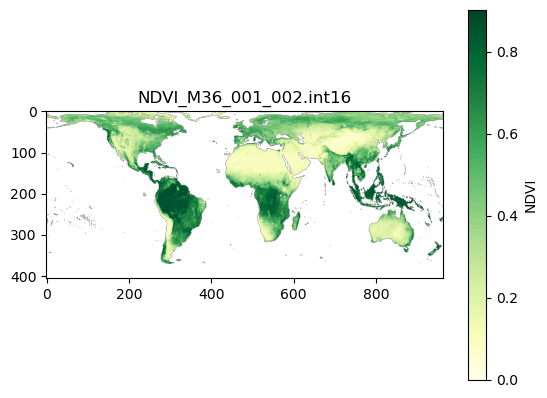

In [5]:
earthaccess.login(persist=True)
aws = earthaccess.get_s3_credentials(daac="NSIDC")
import matplotlib.pyplot as plt

fs = s3fs.S3FileSystem(
    key=aws["accessKeyId"],
    secret=aws["secretAccessKey"],
    token=aws["sessionToken"],
    client_kwargs={"region_name": "us-west-2"},
    requester_pays=True,
    s3_additional_kwargs={"RequestPayer": "requester"}  # important for NSIDC
)

s3_path = "s3://nsidc-cumulus-prod-protected/SMAP-ANC/SMAP_L1_L3_ANC_STATIC/1/2015/01/14/NDVI_M36_001_002.int16"
# Read and reshape
with fs.open(s3_path, "rb") as f:
    data = np.frombuffer(f.read(), dtype=np.int16).reshape((406, 964))

# Scale and mask invalid values
data = np.where(data < 0, np.nan, data) / 10000.0

plt.imshow(data, cmap="YlGn")
plt.colorbar(label="NDVI")
plt.title("NDVI_M36_001_002.int16")
plt.show()

## 3) Discover NISAR via MAAP STAC

In [6]:
try:
    client = Client.open(STAC_URL)
    geom = mapping(box(roi['west'], roi['south'], roi['east'], roi['north']))
    search = client.search(collections=[NISAR['collection']],
                           intersects=geom,
                           max_items=200)
    
    for item in client.search(collections="nisar-sim").items():

        if asset:= item.assets.get("GCOV"):        
            s3_link = asset.extra_fields["alternate"]["href"]
            break

    print(s3_link)
except Exception as e:
    print('NISAR STAC search failed:', e)

s3://sds-n-cumulus-prod-nisar-sample-data/GCOV/ALOS1_Rosamond_20081012/NISAR_L2_PR_GCOV_001_005_A_219_4020_SHNA_A_20081012T060910_20081012T060926_P01101_F_N_J_001.h5


## 4) Discover SMAP

In [42]:
# --- Discover SMAP via earthaccess  ---


# 1) Authenticate (interactive once per session; token can persist)
print("Authenticating with earthaccess...")
auth = earthaccess.login(strategy="interactive", persist=True)
print("✅ Authentication successful.")

SMAP_SHORT_NAME = "SPL3SMP_E"
bbox_tuple = (roi["west"], roi["south"], roi["east"], roi["north"])
CLOUD_PROVIDER = 'NSIDC_ECS'
print(f"\nSearching NSIDC for {smap_short_name} {START_DATE} → {END_DATE} within bbox {bbox_tuple}...")

granules = None


# --- Step 1: Authentication ---
try:
    # Ensure you are authenticated to get the necessary S3 tokens.
    auth = earthaccess.login(strategy='interactive', persist=True)
    print("Authentication successful.")
except Exception as e:
    print(f"Authentication error: {e}")
    # Exit or stop execution if login fails

# --- Step 2: Search for Granules ---
print(f"\nSearching for {SMAP_SHORT_NAME} granules from {START_DATE} to {END_DATE}...")
granules = earthaccess.search_data(
    short_name=SMAP_SHORT_NAME,
    temporal=(START_DATE, END_DATE),
    provider=CLOUD_PROVIDER, # CRITICAL: This filters out the duplicate archive.
    bounding_box=bbox_tuple, 
    cloud_hosted=True        # Ensure we favor the cloud-optimized location.
)

if not granules:
    print("\nNo granules found matching the search criteria.")
else:
    print(f"Found {len(granules)} granules.")



Authenticating with earthaccess...
✅ Authentication successful.

Searching NSIDC for SPL3SMP_E 2019-07-25 → 2019-07-27 within bbox (-118.48, 34.235, -117.47, 35.365)...
Authentication successful.

Searching for SPL3SMP_E granules from 2019-07-25 to 2019-07-27...
Found 2 granules.


In [52]:
from datetime import datetime

# Assuming 'granules' is the list containing the DataGranule objects.

if granules:
    # Select the first granule in the list (index 0)
    first_granule = granules[0]
    
    print("--- Details for the First Granule ---")# 1. Granule ID (FIXED: Using dictionary-style access)
    try:
        # Access the ID using the dictionary key 'id'
        granule_id = first_granule['meta']['native-id']
        print(f"Granule ID: {granule_id}")
    except KeyError:
        print("Granule ID: Not available via standard key access.")

    # 2. Date/Time (Accessing the UMM dictionary structure)
    try:
        start_time_str = first_granule["umm"]["TemporalExtent"]["RangeDateTime"]["BeginningDateTime"]
        date_obj = datetime.fromisoformat(start_time_str.replace('Z', ''))
        print(f"Date/Time: {date_obj}")
    except (KeyError, ValueError):
        print("Date/Time: Not available in standard format.")

    # 3. Geographic Bounding Box
    try:
        bbox_info = (first_granule["umm"]["SpatialExtent"]
        ['HorizontalSpatialDomain']['Geometry']['BoundingRectangles'][0])
    # --- Print the specific coordinates using their exact key names (WestBoundingCoordinate, etc.) ---
        print("Bounding Box (W, S, E, N):")
        print(bbox_info['WestBoundingCoordinate'],bbox_info['SouthBoundingCoordinate'],
              bbox_info['EastBoundingCoordinate'],bbox_info['NorthBoundingCoordinate'])    
        
    except (KeyError, IndexError) as e:
        # Catches errors if any of the keys or list indices are missing
        print(f"Bounding Box: Not available. Error details: {e}")
    
    # 4. S3 Link (Still using the accessor function)
    try:
        s3_link = first_granule.data_links(access='direct')[0]
        print(f"S3 Link: {s3_link}")
    except (IndexError, KeyError, AttributeError):
        print("S3 Link: Not available for direct access.")
        
else:
    print("Error: The 'granules' list is empty. Please run the search script first.")

--- Details for the First Granule ---
Granule ID: SMAP_L3_SM_P_E_20190726_R19240_001.h5
Date/Time: 2019-07-26 00:00:00
Bounding Box (W, S, E, N):
-180 -85.04450225830078 180 85.04450225830078
S3 Link: s3://nsidc-cumulus-prod-protected/SMAP/SPL3SMP_E/006/2019/07/26/SMAP_L3_SM_P_E_20190726_R19240_001.h5
